<a href="https://colab.research.google.com/github/filipes1lva/scripts_tcc_python/blob/main/ann_model_stcond.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modelo II: Sem o uso da condição da ferramenta de corte


In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/BD_TCC/

Mounted at /content/drive
/content/drive/MyDrive/BD_TCC


In [2]:
# Importando bibliotecas necessárias

from skimage import data, io   # Import skimage library (data - Test images and example data.
#                          io - Reading, saving, and displaying images.)
from skimage.color import rgb2gray                  # Import matplotlib.pyplot (Plotting framework in Python.)
%matplotlib inline
import os                                        # This module provides a portable way of using operating system dependent functionality.'
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')
from IPython.display import display
import cv2 as cv
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split 


In [5]:
data = pd.read_csv("Exp2.csv")
data_prep1 = data.copy()

data_prep1.drop(['Run_ID', 'Experiment', 'Replica', 'Tool_ID', 'Group', 'Subgroup',
           'Position', 'Condition',
           'Machined_length', 'Init_diameter', 'Final_diameter', 'CTime', 'R_measurement', 'TCond'],
          axis=1, inplace=True)



def setup_reg(data,target, task='regression'):
    train = data.copy()
    target = target
    if "Set" not in train.columns:
        train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

    train_indices = train[train.Set=="train"].index
    valid_indices = train[train.Set=="valid"].index
    test_indices = train[train.Set=="test"].index

    categorical_columns = []
    categorical_dims =  {}
    for col in train.columns[train.dtypes == object]:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)

    for col in train.columns[train.dtypes == 'float64']:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

    unused_feat = ['Set']

    features = [ col for col in train.columns if col not in unused_feat+[target]] 

    cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

    cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

    

    X_train = train[features].values[train_indices]
    y_train = train[target].values[train_indices].reshape(-1, 1)

    X_valid = train[features].values[valid_indices]
    y_valid = train[target].values[valid_indices].reshape(-1, 1)

    X_test = train[features].values[test_indices]
    y_test = train[target].values[test_indices].reshape(-1, 1)

    return X_train, y_train, X_valid,y_valid, X_test, y_test

data_prep1.tail()

,ap,vc,f,Ra,Rz,Rsk,Rku,RSm,Rt,Fx,Fy,Fz,F
283,0.5,350,0.09,0.488,2.934,0.925,3.603,73.0,3.168,195.1,221.2,174.9,342.904447
284,0.5,350,0.09,0.481,2.872,1.013,3.741,90.8,2.993,195.1,221.2,174.9,342.904447
285,0.5,350,0.09,0.467,2.852,1.060,3.951,77.7,3.156,195.1,221.2,174.9,342.904447
286,0.5,350,0.09,0.481,2.787,0.870,3.386,81.3,3.037,195.1,221.2,174.9,342.904447
287,0.5,350,0.09,0.473,2.958,1.001,3.859,78.5,3.196,195.1,221.2,174.9,342.904447


In [7]:
def create_model():
    model = keras.Sequential()
    model.add(layers.Dense(64, input_dim=7,activation= 'relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, 'relu'))
    model.add(layers.Dense(16, 'relu'))
    model.add(layers.Dense(1))
    
    model.compile(loss="mean_squared_error",
                      optimizer='rmsprop',
                      metrics=["mean_absolute_percentage_error",
                      "mean_absolute_error"])
    return model


early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001, # mínima quantidade para se considerar como melhoria
    patience=600, # Quantas epochs esperar antes de parar
    restore_best_weights=True,
)

In [8]:
from sklearn.metrics import r2_score
import keras.backend as K

data = data_prep1.drop(["Ra", "Rz", "Rsk", "RSm", "Rt"], axis=1)
target = "Rku"
K.clear_session()

sep = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=884734)

for train_index, test_index in sep.split(data_prep1, data_prep1["f"]):
    stratified_train_set = data_prep1.loc[train_index]
    stratified_test_set = data_prep1.loc[test_index]
    
df_train = pd.DataFrame(stratified_train_set)
df_test = pd.DataFrame(stratified_test_set)



X_train_and_valid = df_train.drop(["Ra", "Rz", "Rsk", "Rku", "RSm", "Rt"], axis=1)  
X_test = df_test.drop(["Ra", "Rz", "Rsk", "Rku", "RSm", "Rt"], axis=1)

#3.2 - Variáveis de Saída - Kurtose
y_train = df_train[["Rku"]]  
y_test = df_test[["Rku"]] 

X_train, X_valid,\
y_train, y_valid = train_test_split(X_train_and_valid,y_train,
                                test_size=0.20, random_state=884734)



model = create_model()
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=16,
    epochs=10000,
    callbacks=[early_stopping], # Põe os callbacks na lista
    verbose=0,  
)
x_pred = model.predict(X_test)

r2 = r2_score(y_test, x_pred)
print('O valor de r² é:', r2)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 9,889
Trainable params: 9,889
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 6ms/step
O v

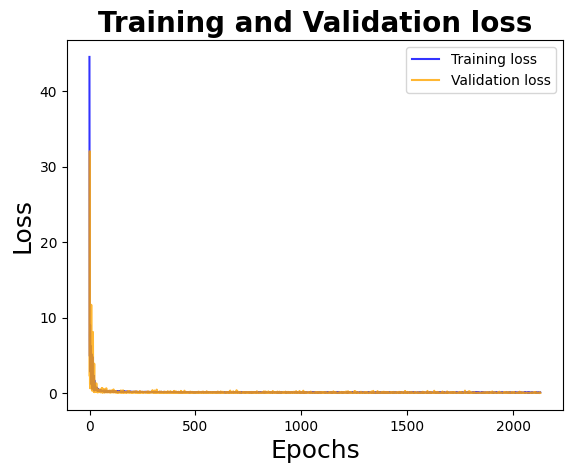

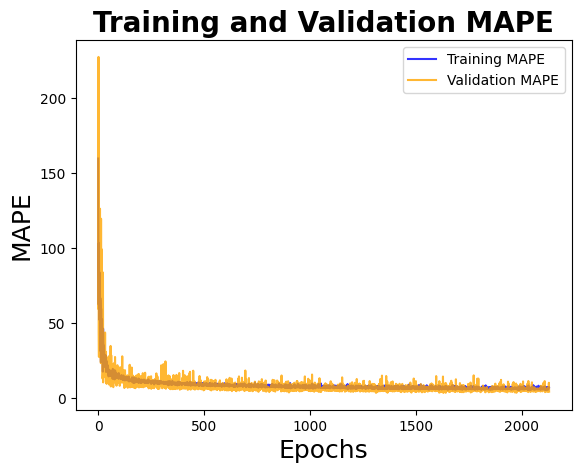

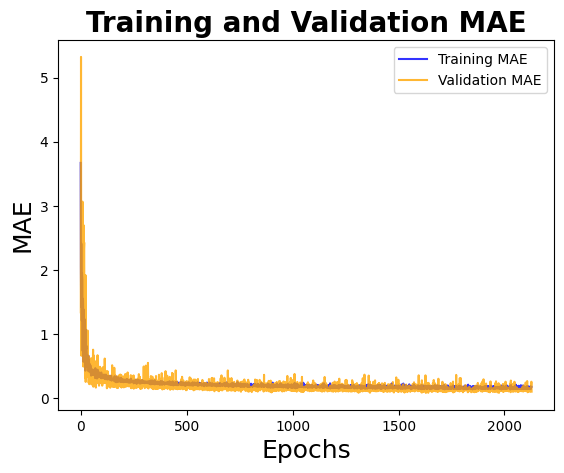

In [9]:
# Visualização das curvas de aprendizado

color = ['black', 'dgray', 'gray', 'dblue', 'blue', 'lblue', 'red', 'orange']

epochs = np.arange(0, len(history.history['loss']))

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs - 0.5, train_loss, color=color[4], alpha=0.8, label='Training loss')
plt.plot(epochs, val_loss, color=color[7], alpha=0.8, label='Validation loss')
plt.title('Training and Validation loss', size=20, fontweight='bold')
plt.xlabel('Epochs', size=18)
plt.ylabel('Loss', size=18)
plt.legend()
plt.show()

train_mape = history.history['mean_absolute_percentage_error']
val_mape = history.history['val_mean_absolute_percentage_error']
plt.plot(epochs - 0.5, train_mape, color=color[4], alpha=0.8, label='Training MAPE')
plt.plot(epochs, val_mape, color=color[7], alpha=0.8, label='Validation MAPE')
plt.title('Training and Validation MAPE', size=20, fontweight='bold')
plt.xlabel('Epochs', size=18)
plt.ylabel('MAPE', size=18)
plt.legend()
plt.show()

train_mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
plt.plot(epochs - 0.5, train_mae, color=color[4], alpha=0.8, label='Training MAE')
plt.plot(epochs, val_mae, color=color[7], alpha=0.8, label='Validation MAE')
plt.title('Training and Validation MAE', size=20, fontweight='bold')
plt.xlabel('Epochs', size=18)
plt.ylabel('MAE', size=18)
plt.legend()
plt.show()

2/2 [==============================] - 0s 4ms/step


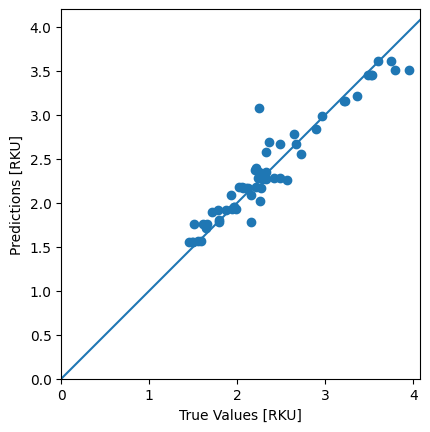

In [10]:
test_predictions = model.predict(X_test).flatten()
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [RKU]')
plt.ylabel('Predictions [RKU]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [11]:
from sklearn.metrics import r2_score

x_pred = model.predict(X_test)

r2 = r2_score(y_test, x_pred)

print('O valor de r² é:', r2)

2/2 [==============================] - 0s 4ms/step
O valor de r² é: 0.9183461229506519


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4167 sha256=f788794d4eb4a9739e9f2fc68ba69981cce1d7b0190b72271e585653a403ea27
  Stored in directory: /root/.cache/pip/wheels/6e/0f/ae/f5dba91db71b1b32bf03d0ad18c32e86126093aba5ec6b6488
Successfully built ann_visualizer


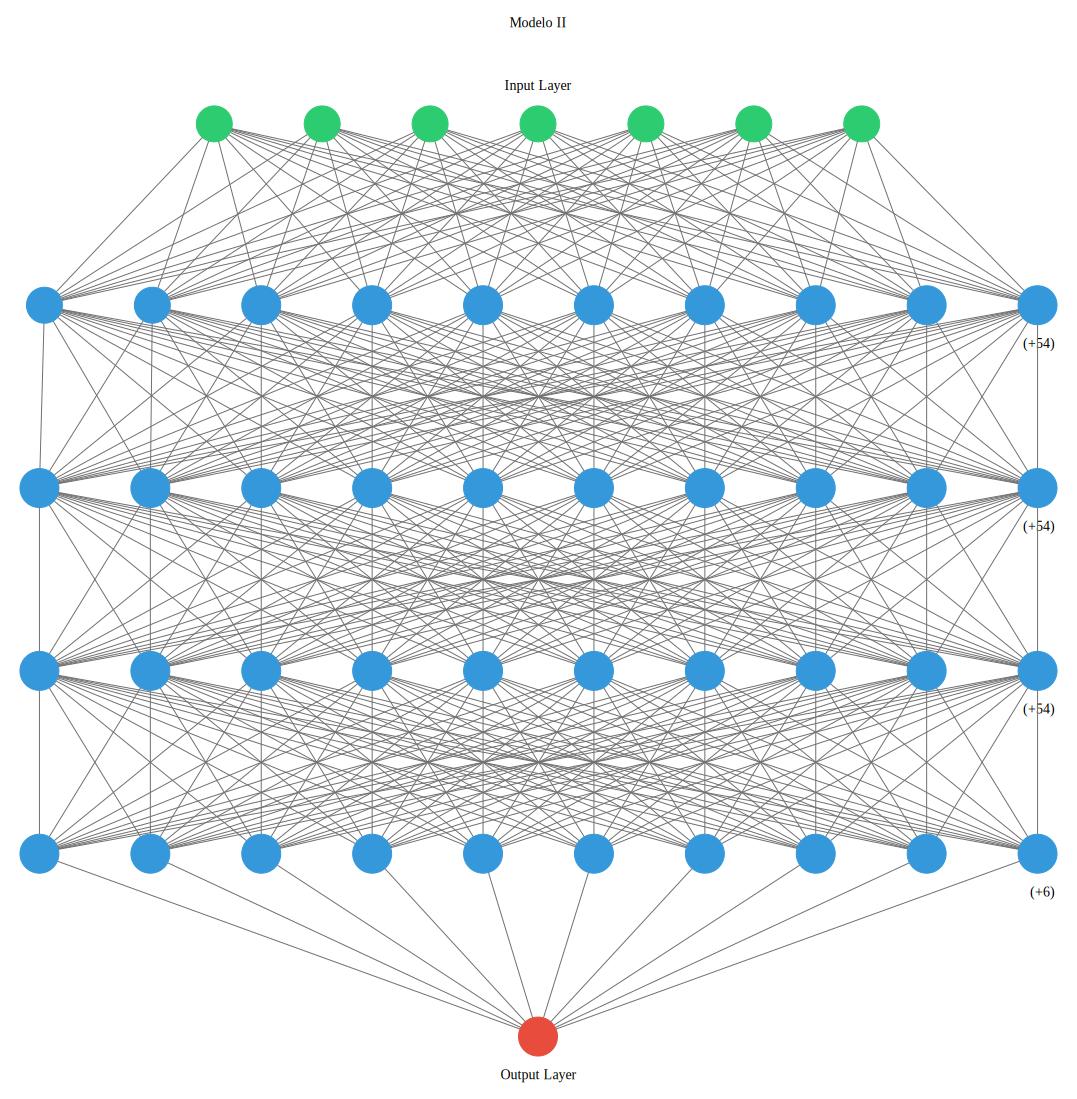

In [13]:
!pip install ann_visualizer

from ann_visualizer.visualize import ann_viz
from graphviz import Source

ann_viz(model, filename= "network.gv", title="Modelo II")
Source.from_file('./network.gv')